In [1]:
import json
import numpy as np


from lttb import LTTB

from gbc import GBC #--> replace with LTTB
from env import Unlock

from tqdm import tqdm, trange
from itertools import product as Prod


# ============= TEST FUNCTION =================
def test (lttb, env, testset, par):
    rt, rb = r = (par['rt'], par['rb'])
    size = np.shape(testset)[-1]

    hist = {'agent'  : np.zeros ((size, par['T'], 2)),
            'action' : np.zeros ((size, par['T'], par['O'])),
            'theta'  : np.zeros (size),
            'R'      : np.zeros (size)}

    tars = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in testset])
    btns =  [(0., rb)] * len (testset)

    for i, (targ, btn) in enumerate (zip (tars, btns)):
        env.reset (init = init, targ = targ, btn = btn)
        lttb.initialize(par)
        R = 0

        state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

        for t in range (par['T']):
            action, _ = lttb.step (apicalFactor =0)
            state, r, done, agen = env.step (action)

            R = max (R, r)

            hist['action'][i, t] = action
            hist['agent'][i, t]  = agen

            if done: break

        hist['action'][i, t:] = np.nan
        hist['agent'][i, t:]  = agen
        hist['theta'][i]      = testset[i]
        hist['R'][i]          = R

    return hist

In [2]:
# Loading configuration file
path = 'config.json'
config = 'BUTTON_FOOD'

with open (path, 'r') as f:
    par = json.load (f)[config]

par['hint'] = par['hint'] == 'True'
par['clump'] = par['clump'] == 'True'
par['validate'] = par['validate'] == 'True'
par['verbose'] = par['verbose'] == 'True'

# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (par['dt'], par['dx']), res = 20)

rt, rb = par['rt'], par['rb']

trainset = np.array (par['trainset'])
validset = np.array (par['validset'])
testset  = np.linspace (*par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

train_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in train_theta])
valid_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in valid_theta])

train_bttns = np.array ([(0, rb) for t in train_theta])
valid_bttns = np.array ([(rb * np.cos (t), rb * np.sin (t)) for t in valid_theta])

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (29, 49), 'T' : (30, 50)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]




In [3]:
train_bttns

array([[ 0. , -0.2],
       [ 0. , -0.2]])

array([[ 0. , -0.2],
       [ 0. , -0.2]])

In [4]:
import matplotlib.pyplot as plt

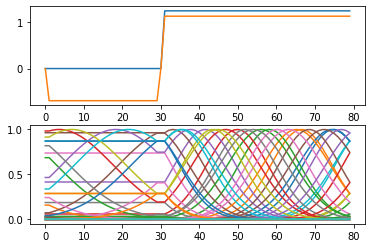

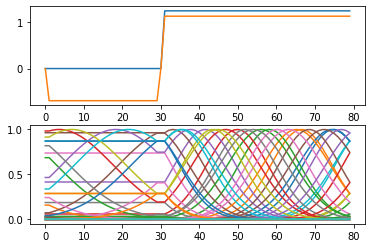

In [5]:
plt.figure()
plt.subplot(211)
plt.plot(train_exp[0][1].T)
plt.subplot(212)
plt.plot(train_exp[0][0].T)
plt.show()

In [6]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 80, 2, 80
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 0.
sigma_targ = 25.#10**1.5
sigma_in = 12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = 2

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 10

JMAX = 100.
nu_targ = 0.005


# Here we init our (recurrent) agent
lttb = LTTB (par)



0
1
0
1


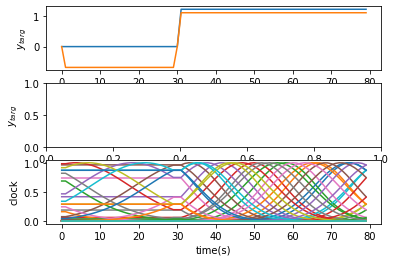

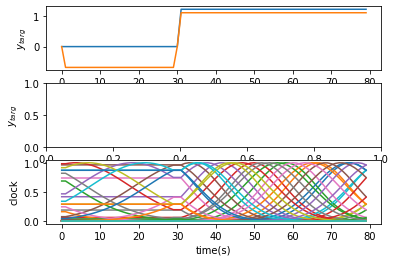

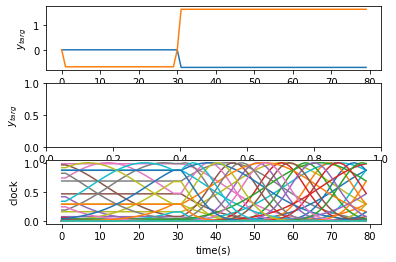

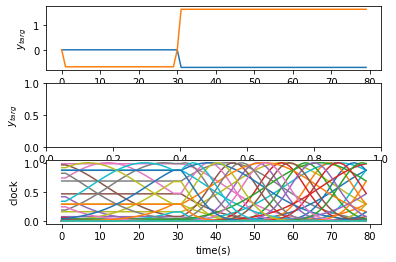

In [7]:
# define clock and target

lttb.y_targ_collection = []
lttb.I_clock_collection = []

for k in range(n_contexts):
    print(k)
    lttb.y_targ_collection.append(train_exp[k][1])
    lttb.I_clock_collection.append( train_exp[k][0] )

#(par)


    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[k]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(312)
    plt.ylabel('$y_{targ}$')
    plt.subplot(313)
    plt.plot(np.array(lttb.I_clock_collection[k]).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')



0
1
0
1


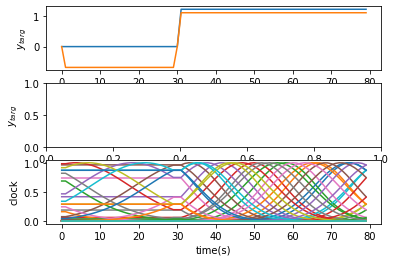

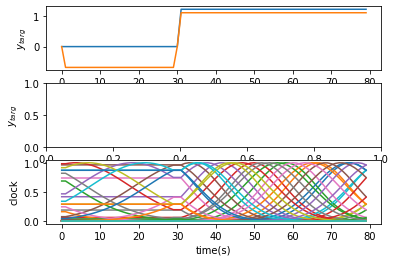

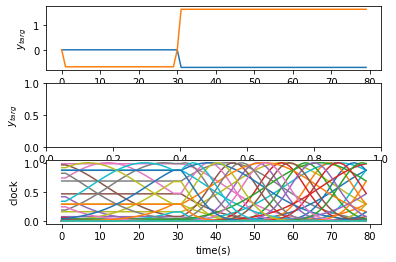

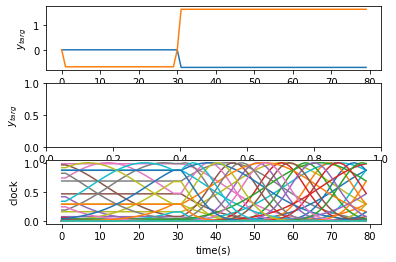

In [8]:
# define clock and target

lttb.y_targ_collection = []
lttb.I_clock_collection = []

for k in range(n_contexts):
    print(k)
    lttb.y_targ_collection.append(train_exp[k][1])
    lttb.I_clock_collection.append( train_exp[k][0] )

#(par)


    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[k]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(312)
    plt.ylabel('$y_{targ}$')
    plt.subplot(313)
    plt.plot(np.array(lttb.I_clock_collection[k]).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')




In [30]:
## Training Rec

gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 150

eta = 5.
eta_out = 0.05
etaW = .0

for iter in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_contexts):
    
        lttb.cont = lttb.cont*0
        lttb.cont[cont_index] = 1
        
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        lttb.I_clock = lttb.I_clock_collection[cont_index]
        
        lttb.initialize(par)

        #run simulation
        dH = 0

        for t in range(lttb.T-2):
            
            lttb.step(apicalFactor = apicalFactorTrain)

            dH = dH*(1-dt/tau_m) + dt/tau_m*lttb.S_filt[:,t]

            DJ = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_dist[:,t]) ,dH)
            lttb.J =  lttb.J + eta*DJ

            SR = lttb.B_filt_rec[:,t+1]#lttb.S_filtRO[:,t+1]#
            Y = lttb.Jout@SR
            DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
            lttb.Jout =  lttb.Jout + eta_out*DJRO
        
    ###### Test
    
    if iter%5==0:

        for cont_index in range(n_contexts):

            lttb.cont = lttb.cont*0
            lttb.cont[cont_index] = 1
            
            
            lttb.I_clock = lttb.I_clock_collection[cont_index]
            lttb.y_targ = lttb.y_targ_collection[cont_index]

            lttb.initialize(par)

            #run simulation

            for t in range(lttb.T-2):
                
                lttb.step(apicalFactor = apicalFactorTest)

            SR = lttb.B_filt_rec[:,1:-2]#lttb.S_filtRO[:,1:-2]# 
            Y = lttb.Jout@SR
            mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

            print(mse_rec_train)
            

0.08715474069937411
0.799935275648955
0.08715474069937411
0.799935275648955
0.0746821773503154
0.48469394663193777
0.0746821773503154
0.48469394663193777
0.06918475681181809
0.303592122050158
0.06918475681181809
0.303592122050158
0.06692871048122102
0.2951664774596393
0.06692871048122102
0.2951664774596393
0.06332221678552938
0.33178808596065706
0.06332221678552938
0.33178808596065706
0.06469688524332767
0.542829393779028
0.06469688524332767
0.542829393779028
0.060045639460404025
0.3287271108754627
0.060045639460404025
0.3287271108754627
0.05868617431883202
0.16615178554115725
0.05868617431883202
0.16615178554115725
0.057140096237158405
0.14769992104526516
0.057140096237158405
0.14769992104526516
0.058088787662012156
0.13947129557182078
0.058088787662012156
0.13947129557182078
0.05466376624164294
0.18000546873411075
0.05466376624164294
0.18000546873411075
0.053788786187222146
0.14993024982285685
0.053788786187222146
0.14993024982285685
0.050248879867305266
0.1635499861752349
0.05024887

In [13]:
lttb.T

80

80

0.042691448121107145
0.042691448121107145


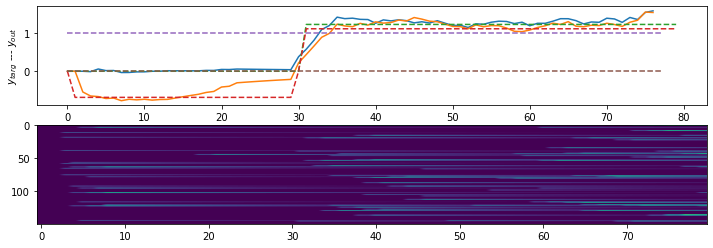

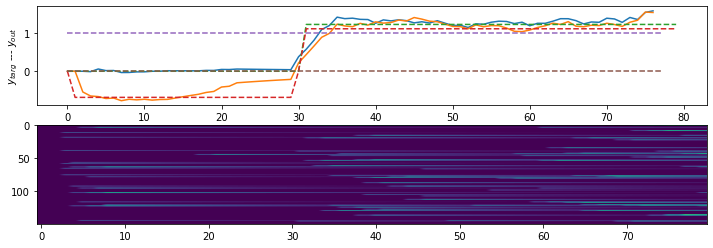

0.08212325378439793
0.08212325378439793


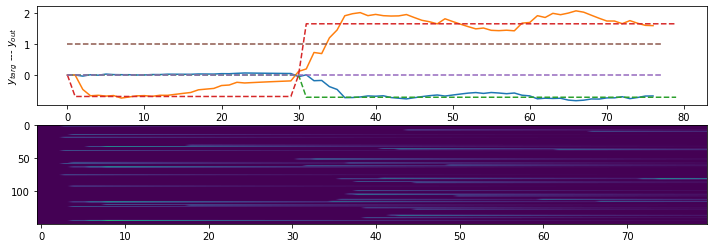

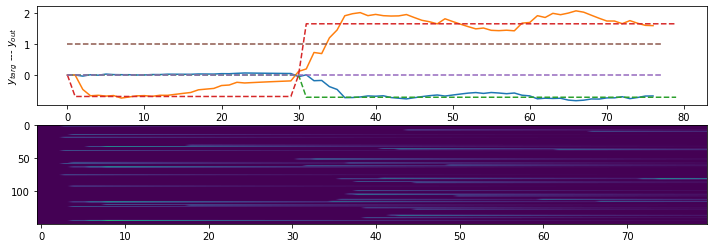

In [31]:
for cont_index in range(n_contexts):
    
    context = []

    lttb.cont = lttb.cont*0
    lttb.cont[cont_index] = 1
    
    lttb.I_clock = lttb.I_clock_collection[cont_index]

    lttb.y_targ = lttb.y_targ_collection[cont_index]

    lttb.initialize(par)

    #run simulation
    
    apicalFactor = 0

    for t in range(lttb.T-2):
 
        if t==200:
            apicalFactor = 0
            #lttb.cont = lttb.cont*0.1
            #lttb.cont[0] = 1
        context.append(lttb.cont)
          
        lttb.step(apicalFactor = apicalFactor)

    SR = lttb.B_filt_rec[:,1:-2]#lttb.S_filtRO[:,1:-2]#
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    plt.plot(Y.T)
    plt.plot(lttb.y_targ.T,'--')
    plt.plot(np.array(context),'--')
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.B_filt_rec[0:150,:],aspect='auto')
    #plt.plot(lttb.B_filt_rec.T)
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

In [35]:
a = 0.

targ_test = (train_targs[1]*a+train_targs[0]*(1-a))
btn_test = train_bttns[1]

env.reset (init = init, targ = targ_test, btn = btn_test)
lttb.initialize(par)
R = 0

ACTIONS = []
    
state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

trajectory = np.zeros((2,par["T"]-1))

trajectory[:,0] = init

lttb.I_clock[:,0] *= 0

for t in range (par['T']-2):
    
    lttb.step (apicalFactor = 0)
    action = lttb.Jout@lttb.B_filt_rec[:,t]
    ACTIONS.append(action)
    
    trajectory[:,t+1] = trajectory[:,t] + action*.01
    
    
    state, r, done, agen = env.step (action)
    lttb.I_clock[:,lttb.t+1] = state

    R = max (R, r)
    
    if done: break


In [36]:
R


1.3195760939576182

1.3195760939576182

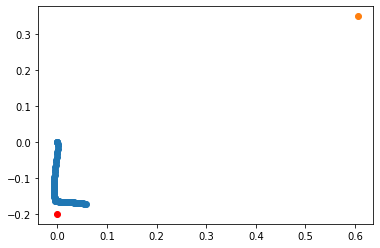

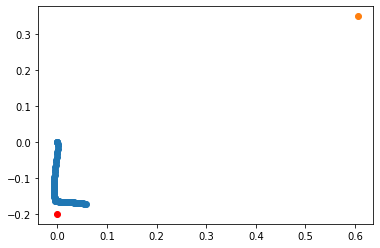

In [37]:
plt.figure()
plt.plot(trajectory[0],trajectory[1],'o')
plt.plot(targ_test[0],targ_test[1],'o')
plt.plot(btn_test[0],btn_test[1],'ro')


In [27]:
R

0

0

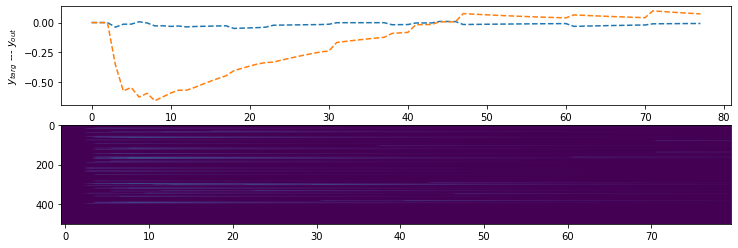

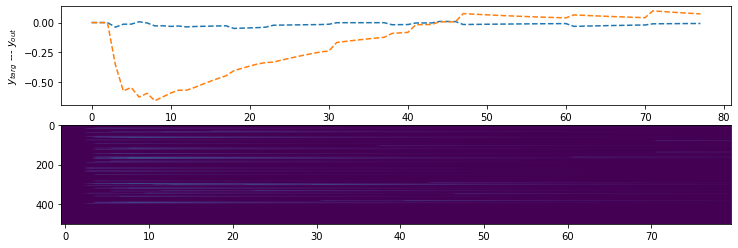

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(211)
plt.plot(np.array(ACTIONS),'--')
#plt.plot(np.array(context),'--')
    
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.subplot(212)
plt.imshow(lttb.B_filt_rec[0:500,:],aspect='auto')
    